In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sharansmenon_inat2021birds_path = kagglehub.dataset_download('sharansmenon/inat2021birds')

print('Data source import complete.')


100%|██████████| 5.11G/5.11G [04:57<00:00, 18.4MB/s]

Extracting files...


Data source import complete.


In [ ]:
# !pip install -U torch torchvision

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [4]:
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [5]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu102', '1.10.1+cu102')

('0.20.1+cu121', '2.5.1+cu121')

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import os
import sys
from tqdm import tqdm
import time
import copy

In [9]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=bad8aedc9d729d60ce7b26b525f2f68149daf7647f7adc7bba628cb63b5b510b
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [10]:
# importing cam utilities
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [11]:
def get_classes(data_dir):
    dataset = CustomImageFolder(data_dir + "/bird_train")
    return dataset.classes  # Use the 'classes' attribute directly


In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch

from torchvision.datasets import ImageFolder


class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Use original folder names as class names
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Store the original class names for later use
        self.original_classes = classes
        return classes, class_to_idx

    def __getitem__(self, index):
        # Default behavior: get image tensor and original integer label
        sample, original_target = super().__getitem__(index)
        # Map original target to its corresponding class name if needed
        original_class_name = self.original_classes[original_target]
        return sample, original_target  # Return processed target directly if no mapping is required





def get_data_loaders(data_dir, batch_size):
    # Transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.2, value='random')
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load dataset
    all_data = CustomImageFolder(data_dir + "/bird_train", transform=train_transform)
    train_data_len = int(len(all_data) * 0.78)
    valid_data_len = int((len(all_data) - train_data_len) / 2)
    test_data_len = len(all_data) - train_data_len - valid_data_len

    train_data, val_data, test_data = random_split(
        all_data, [train_data_len, valid_data_len, test_data_len]
    )

    # Apply different transforms to validation and test datasets
    val_data.dataset.transform = eval_transform
    test_data.dataset.transform = eval_transform

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len







In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch

class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Get all original folder names
        original_classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        # Generate processed class names
        processed_classes = ['_'.join(cls.split('_')[2:-2]) for cls in original_classes]
        # Deduplicate processed class names in case of overlaps
        processed_classes = sorted(set(processed_classes))

        # Map processed class names to indices
        class_to_idx = {cls: i for i, cls in enumerate(processed_classes)}

        # Create a reverse map for original class names to processed class indices
        original_to_processed_idx = {
            original: class_to_idx['_'.join(original.split('_')[2:-2])] for original in original_classes
        }

        # Store the mapping internally
        self.original_to_processed_idx = original_to_processed_idx
        self.classes = processed_classes  # Override to use processed class names
        return processed_classes, class_to_idx

    def __getitem__(self, index):
        # Default behavior: get image tensor and original integer label
        sample, original_target = super().__getitem__(index)
        # Map original target to processed class index
        processed_target = self.original_to_processed_idx[self.classes[original_target]]
        return sample, torch.tensor(processed_target)


def get_data_loaders(data_dir, batch_size, train=False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.2, value='random')
        ])
        all_data = CustomImageFolder(data_dir + "/bird_train", transform=transform)
        train_data_len = int(len(all_data) * 0.78)
        valid_data_len = int((len(all_data) - train_data_len) / 2)
        test_data_len = len(all_data) - train_data_len - valid_data_len
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len

    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        all_data = CustomImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data) * 0.78)
        valid_data_len = int((len(all_data) - train_data_len) / 2)
        test_data_len = len(all_data) - train_data_len - valid_data_len
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, valid_data_len, test_data_len


dataset_path = sharansmenon_inat2021birds_path
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 128, train=False)
classes = get_classes(dataset_path)

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir + "/bird_train")
    processed_classes = ['_'.join(cls.split('_')[2:-2]) for cls in all_data.classes]  # Remove first and last two words
    return processed_classes

In [15]:
dataset_path = sharansmenon_inat2021birds_path
train_loader, val_loader, test_loader, train_data_len, valid_data_len, test_data_len = get_data_loaders(dataset_path, 128)
classes = get_classes(dataset_path)


In [16]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [18]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

453
64
64


In [17]:
print(train_data_len, test_data_len, valid_data_len)

57954 8173 8173


In [19]:
def formatText(class_label):
    return " ".join(class_label.split("_")[-1:])

In [20]:
classes[0]

'03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius'

In [ ]:
labels[0]

NameError: name 'labels' is not defined

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter) # Change dataiter.next() to next(dataiter)
images = images.numpy() # convert images to numpy for display

for i in np.arange(20):
    print((classes[labels[i]]))

03594_Animalia_Chordata_Aves_Falconiformes_Falconidae_Falco_berigora
03866_Animalia_Chordata_Aves_Passeriformes_Icteridae_Agelaioides_badius
03850_Animalia_Chordata_Aves_Passeriformes_Hirundinidae_Hirundo_smithii
03633_Animalia_Chordata_Aves_Galliformes_Phasianidae_Lagopus_lagopus
04551_Animalia_Chordata_Aves_Strigiformes_Strigidae_Glaucidium_brasilianum
04015_Animalia_Chordata_Aves_Passeriformes_Oriolidae_Oriolus_larvatus
03418_Animalia_Chordata_Aves_Charadriiformes_Laridae_Larus_glaucoides
03275_Animalia_Chordata_Aves_Anseriformes_Anatidae_Tadorna_tadornoides
03502_Animalia_Chordata_Aves_Ciconiiformes_Ciconiidae_Ciconia_ciconia
03182_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Rupornis_magnirostris
04428_Animalia_Chordata_Aves_Piciformes_Picidae_Colaptes_campestris
03488_Animalia_Chordata_Aves_Charadriiformes_Scolopacidae_Tringa_erythropus
03201_Animalia_Chordata_Aves_Anseriformes_Anatidae_Anas_platyrhynchos
03692_Animalia_Chordata_Aves_Passeriformes_Alaudidae_Eremophila_alpe

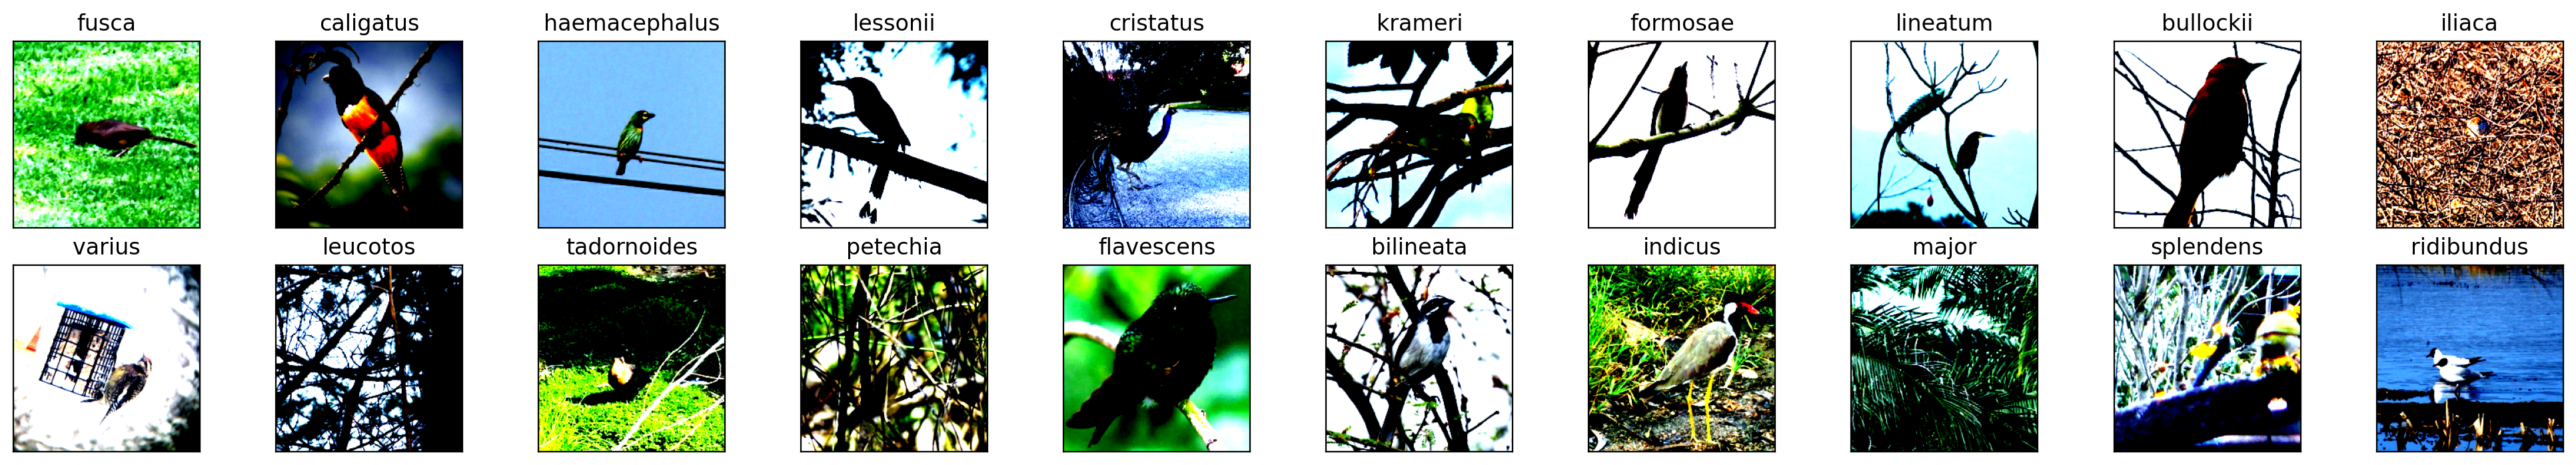

In [21]:
dataiter = iter(train_loader)
images, labels = next(dataiter) # Change dataiter.next() to next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(formatText(classes[labels[idx]]))

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
torch.backends.cudnn.benchmark = True

In [24]:
# model = models.efficientnet_b3(pretrained=True)
model = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
# model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

In [25]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=1486, bias=True)
)


In [26]:
criterion = LabelSmoothingCrossEntropy()
# criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [27]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [28]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|██████████| 453/453 [05:38<00:00,  1.34it/s]


train Loss: 4.4659 Acc: 0.2583


100%|██████████| 64/64 [00:47<00:00,  1.35it/s]


val Loss: 5.0805 Acc: 0.1621

Epoch 1/9
----------


100%|██████████| 453/453 [05:39<00:00,  1.34it/s]


train Loss: 3.6773 Acc: 0.4106


100%|██████████| 64/64 [00:48<00:00,  1.32it/s]


val Loss: 5.1814 Acc: 0.1761

Epoch 2/9
----------


100%|██████████| 453/453 [05:35<00:00,  1.35it/s]


train Loss: 2.9956 Acc: 0.5754


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 5.3361 Acc: 0.1779

Epoch 3/9
----------


100%|██████████| 453/453 [05:33<00:00,  1.36it/s]


train Loss: 2.4489 Acc: 0.7266


100%|██████████| 64/64 [00:48<00:00,  1.31it/s]


val Loss: 5.4952 Acc: 0.1763

Epoch 4/9
----------


100%|██████████| 453/453 [05:29<00:00,  1.37it/s]


train Loss: 2.0571 Acc: 0.8427


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


val Loss: 5.6178 Acc: 0.1728

Epoch 5/9
----------


100%|██████████| 453/453 [05:34<00:00,  1.35it/s]


train Loss: 1.8063 Acc: 0.9176


100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


val Loss: 5.6298 Acc: 0.1750

Epoch 6/9
----------


100%|██████████| 453/453 [05:29<00:00,  1.37it/s]


train Loss: 1.6677 Acc: 0.9502


100%|██████████| 64/64 [00:44<00:00,  1.43it/s]


val Loss: 5.6477 Acc: 0.1682

Epoch 7/9
----------


100%|██████████| 453/453 [05:29<00:00,  1.37it/s]


train Loss: 1.5982 Acc: 0.9651


100%|██████████| 64/64 [00:47<00:00,  1.36it/s]


val Loss: 5.6679 Acc: 0.1680

Epoch 8/9
----------


100%|██████████| 453/453 [05:30<00:00,  1.37it/s]


train Loss: 1.5520 Acc: 0.9726


100%|██████████| 64/64 [00:48<00:00,  1.31it/s]


val Loss: 5.6793 Acc: 0.1695

Epoch 9/9
----------


100%|██████████| 453/453 [05:26<00:00,  1.39it/s]


train Loss: 1.5158 Acc: 0.9782


100%|██████████| 64/64 [00:46<00:00,  1.37it/s]

val Loss: 5.6877 Acc: 0.1682

Training complete in 63m 19s
Best val Acc: 0.177903


In [32]:
import torch

# Specify the path where the model should be saved
model_save_path = "trained_model.pth"

# Save the model's state_dict (recommended)
torch.save(model_ft.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to trained_model.pth


In [33]:
from google.colab import files

# Path to the saved model
model_save_path = "trained_model.pth"

# Download the model file
files.download(model_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
num_classes = len(dataloaders['train'].dataset.dataset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 1486


In [ ]:
# Load the model architecture (ensure it matches the saved model)
from torchvision import models

model_ft = models.resnet18(pretrained=False)  # Replace with your model architecture
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)  # Replace num_classes with the number of your classes

# Load the saved weights
model_ft.load_state_dict(torch.load(model_save_path))

# Put the model in evaluation mode for inference
model_ft.eval()

print("Model loaded and ready for inference.")


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv_stem.weight", "blocks.0.0.conv.weight", "blocks.0.0.bn1.weight", "blocks.0.0.bn1.bias", "blocks.0.0.bn1.running_mean", "blocks.0.0.bn1.running_var", "blocks.0.0.bn1.num_batches_tracked", "blocks.1.0.conv_exp.weight", "blocks.1.0.bn1.weight", "blocks.1.0.bn1.bias", "blocks.1.0.bn1.running_mean", "blocks.1.0.bn1.running_var", "blocks.1.0.bn1.num_batches_tracked", "blocks.1.0.conv_pwl.weight", "blocks.1.0.bn2.weight", "blocks.1.0.bn2.bias", "blocks.1.0.bn2.running_mean", "blocks.1.0.bn2.running_var", "blocks.1.0.bn2.num_batches_tracked", "blocks.1.1.conv_exp.weight", "blocks.1.1.bn1.weight", "blocks.1.1.bn1.bias", "blocks.1.1.bn1.running_mean", "blocks.1.1.bn1.running_var", "blocks.1.1.bn1.num_batches_tracked", "blocks.1.1.conv_pwl.weight", "blocks.1.1.bn2.weight", "blocks.1.1.bn2.bias", "blocks.1.1.bn2.running_mean", "blocks.1.1.bn2.running_var", "blocks.1.1.bn2.num_batches_tracked", "blocks.2.0.conv_exp.weight", "blocks.2.0.bn1.weight", "blocks.2.0.bn1.bias", "blocks.2.0.bn1.running_mean", "blocks.2.0.bn1.running_var", "blocks.2.0.bn1.num_batches_tracked", "blocks.2.0.conv_pwl.weight", "blocks.2.0.bn2.weight", "blocks.2.0.bn2.bias", "blocks.2.0.bn2.running_mean", "blocks.2.0.bn2.running_var", "blocks.2.0.bn2.num_batches_tracked", "blocks.2.1.conv_exp.weight", "blocks.2.1.bn1.weight", "blocks.2.1.bn1.bias", "blocks.2.1.bn1.running_mean", "blocks.2.1.bn1.running_var", "blocks.2.1.bn1.num_batches_tracked", "blocks.2.1.conv_pwl.weight", "blocks.2.1.bn2.weight", "blocks.2.1.bn2.bias", "blocks.2.1.bn2.running_mean", "blocks.2.1.bn2.running_var", "blocks.2.1.bn2.num_batches_tracked", "blocks.3.0.conv_pw.weight", "blocks.3.0.bn1.weight", "blocks.3.0.bn1.bias", "blocks.3.0.bn1.running_mean", "blocks.3.0.bn1.running_var", "blocks.3.0.bn1.num_batches_tracked", "blocks.3.0.conv_dw.weight", "blocks.3.0.bn2.weight", "blocks.3.0.bn2.bias", "blocks.3.0.bn2.running_mean", "blocks.3.0.bn2.running_var", "blocks.3.0.bn2.num_batches_tracked", "blocks.3.0.se.conv_reduce.weight", "blocks.3.0.se.conv_reduce.bias", "blocks.3.0.se.conv_expand.weight", "blocks.3.0.se.conv_expand.bias", "blocks.3.0.conv_pwl.weight", "blocks.3.0.bn3.weight", "blocks.3.0.bn3.bias", "blocks.3.0.bn3.running_mean", "blocks.3.0.bn3.running_var", "blocks.3.0.bn3.num_batches_tracked", "blocks.3.1.conv_pw.weight", "blocks.3.1.bn1.weight", "blocks.3.1.bn1.bias", "blocks.3.1.bn1.running_mean", "blocks.3.1.bn1.running_var", "blocks.3.1.bn1.num_batches_tracked", "blocks.3.1.conv_dw.weight", "blocks.3.1.bn2.weight", "blocks.3.1.bn2.bias", "blocks.3.1.bn2.running_mean", "blocks.3.1.bn2.running_var", "blocks.3.1.bn2.num_batches_tracked", "blocks.3.1.se.conv_reduce.weight", "blocks.3.1.se.conv_reduce.bias", "blocks.3.1.se.conv_expand.weight", "blocks.3.1.se.conv_expand.bias", "blocks.3.1.conv_pwl.weight", "blocks.3.1.bn3.weight", "blocks.3.1.bn3.bias", "blocks.3.1.bn3.running_mean", "blocks.3.1.bn3.running_var", "blocks.3.1.bn3.num_batches_tracked", "blocks.3.2.conv_pw.weight", "blocks.3.2.bn1.weight", "blocks.3.2.bn1.bias", "blocks.3.2.bn1.running_mean", "blocks.3.2.bn1.running_var", "blocks.3.2.bn1.num_batches_tracked", "blocks.3.2.conv_dw.weight", "blocks.3.2.bn2.weight", "blocks.3.2.bn2.bias", "blocks.3.2.bn2.running_mean", "blocks.3.2.bn2.running_var", "blocks.3.2.bn2.num_batches_tracked", "blocks.3.2.se.conv_reduce.weight", "blocks.3.2.se.conv_reduce.bias", "blocks.3.2.se.conv_expand.weight", "blocks.3.2.se.conv_expand.bias", "blocks.3.2.conv_pwl.weight", "blocks.3.2.bn3.weight", "blocks.3.2.bn3.bias", "blocks.3.2.bn3.running_mean", "blocks.3.2.bn3.running_var", "blocks.3.2.bn3.num_batches_tracked", "blocks.4.0.conv_pw.weight", "blocks.4.0.bn1.weight", "blocks.4.0.bn1.bias", "blocks.4.0.bn1.running_mean", "blocks.4.0.bn1.running_var", "blocks.4.0.bn1.num_batches_tracked", "blocks.4.0.conv_dw.weight", "blocks.4.0.bn2.weight", "blocks.4.0.bn2.bias", "blocks.4.0.bn2.running_mean", "blocks.4.0.bn2.running_var", "blocks.4.0.bn2.num_batches_tracked", "blocks.4.0.se.conv_reduce.weight", "blocks.4.0.se.conv_reduce.bias", "blocks.4.0.se.conv_expand.weight", "blocks.4.0.se.conv_expand.bias", "blocks.4.0.conv_pwl.weight", "blocks.4.0.bn3.weight", "blocks.4.0.bn3.bias", "blocks.4.0.bn3.running_mean", "blocks.4.0.bn3.running_var", "blocks.4.0.bn3.num_batches_tracked", "blocks.4.1.conv_pw.weight", "blocks.4.1.bn1.weight", "blocks.4.1.bn1.bias", "blocks.4.1.bn1.running_mean", "blocks.4.1.bn1.running_var", "blocks.4.1.bn1.num_batches_tracked", "blocks.4.1.conv_dw.weight", "blocks.4.1.bn2.weight", "blocks.4.1.bn2.bias", "blocks.4.1.bn2.running_mean", "blocks.4.1.bn2.running_var", "blocks.4.1.bn2.num_batches_tracked", "blocks.4.1.se.conv_reduce.weight", "blocks.4.1.se.conv_reduce.bias", "blocks.4.1.se.conv_expand.weight", "blocks.4.1.se.conv_expand.bias", "blocks.4.1.conv_pwl.weight", "blocks.4.1.bn3.weight", "blocks.4.1.bn3.bias", "blocks.4.1.bn3.running_mean", "blocks.4.1.bn3.running_var", "blocks.4.1.bn3.num_batches_tracked", "blocks.4.2.conv_pw.weight", "blocks.4.2.bn1.weight", "blocks.4.2.bn1.bias", "blocks.4.2.bn1.running_mean", "blocks.4.2.bn1.running_var", "blocks.4.2.bn1.num_batches_tracked", "blocks.4.2.conv_dw.weight", "blocks.4.2.bn2.weight", "blocks.4.2.bn2.bias", "blocks.4.2.bn2.running_mean", "blocks.4.2.bn2.running_var", "blocks.4.2.bn2.num_batches_tracked", "blocks.4.2.se.conv_reduce.weight", "blocks.4.2.se.conv_reduce.bias", "blocks.4.2.se.conv_expand.weight", "blocks.4.2.se.conv_expand.bias", "blocks.4.2.conv_pwl.weight", "blocks.4.2.bn3.weight", "blocks.4.2.bn3.bias", "blocks.4.2.bn3.running_mean", "blocks.4.2.bn3.running_var", "blocks.4.2.bn3.num_batches_tracked", "blocks.4.3.conv_pw.weight", "blocks.4.3.bn1.weight", "blocks.4.3.bn1.bias", "blocks.4.3.bn1.running_mean", "blocks.4.3.bn1.running_var", "blocks.4.3.bn1.num_batches_tracked", "blocks.4.3.conv_dw.weight", "blocks.4.3.bn2.weight", "blocks.4.3.bn2.bias", "blocks.4.3.bn2.running_mean", "blocks.4.3.bn2.running_var", "blocks.4.3.bn2.num_batches_tracked", "blocks.4.3.se.conv_reduce.weight", "blocks.4.3.se.conv_reduce.bias", "blocks.4.3.se.conv_expand.weight", "blocks.4.3.se.conv_expand.bias", "blocks.4.3.conv_pwl.weight", "blocks.4.3.bn3.weight", "blocks.4.3.bn3.bias", "blocks.4.3.bn3.running_mean", "blocks.4.3.bn3.running_var", "blocks.4.3.bn3.num_batches_tracked", "blocks.4.4.conv_pw.weight", "blocks.4.4.bn1.weight", "blocks.4.4.bn1.bias", "blocks.4.4.bn1.running_mean", "blocks.4.4.bn1.running_var", "blocks.4.4.bn1.num_batches_tracked", "blocks.4.4.conv_dw.weight", "blocks.4.4.bn2.weight", "blocks.4.4.bn2.bias", "blocks.4.4.bn2.running_mean", "blocks.4.4.bn2.running_var", "blocks.4.4.bn2.num_batches_tracked", "blocks.4.4.se.conv_reduce.weight", "blocks.4.4.se.conv_reduce.bias", "blocks.4.4.se.conv_expand.weight", "blocks.4.4.se.conv_expand.bias", "blocks.4.4.conv_pwl.weight", "blocks.4.4.bn3.weight", "blocks.4.4.bn3.bias", "blocks.4.4.bn3.running_mean", "blocks.4.4.bn3.running_var", "blocks.4.4.bn3.num_batches_tracked", "blocks.5.0.conv_pw.weight", "blocks.5.0.bn1.weight", "blocks.5.0.bn1.bias", "blocks.5.0.bn1.running_mean", "blocks.5.0.bn1.running_var", "blocks.5.0.bn1.num_batches_tracked", "blocks.5.0.conv_dw.weight", "blocks.5.0.bn2.weight", "blocks.5.0.bn2.bias", "blocks.5.0.bn2.running_mean", "blocks.5.0.bn2.running_var", "blocks.5.0.bn2.num_batches_tracked", "blocks.5.0.se.conv_reduce.weight", "blocks.5.0.se.conv_reduce.bias", "blocks.5.0.se.conv_expand.weight", "blocks.5.0.se.conv_expand.bias", "blocks.5.0.conv_pwl.weight", "blocks.5.0.bn3.weight", "blocks.5.0.bn3.bias", "blocks.5.0.bn3.running_mean", "blocks.5.0.bn3.running_var", "blocks.5.0.bn3.num_batches_tracked", "blocks.5.1.conv_pw.weight", "blocks.5.1.bn1.weight", "blocks.5.1.bn1.bias", "blocks.5.1.bn1.running_mean", "blocks.5.1.bn1.running_var", "blocks.5.1.bn1.num_batches_tracked", "blocks.5.1.conv_dw.weight", "blocks.5.1.bn2.weight", "blocks.5.1.bn2.bias", "blocks.5.1.bn2.running_mean", "blocks.5.1.bn2.running_var", "blocks.5.1.bn2.num_batches_tracked", "blocks.5.1.se.conv_reduce.weight", "blocks.5.1.se.conv_reduce.bias", "blocks.5.1.se.conv_expand.weight", "blocks.5.1.se.conv_expand.bias", "blocks.5.1.conv_pwl.weight", "blocks.5.1.bn3.weight", "blocks.5.1.bn3.bias", "blocks.5.1.bn3.running_mean", "blocks.5.1.bn3.running_var", "blocks.5.1.bn3.num_batches_tracked", "blocks.5.2.conv_pw.weight", "blocks.5.2.bn1.weight", "blocks.5.2.bn1.bias", "blocks.5.2.bn1.running_mean", "blocks.5.2.bn1.running_var", "blocks.5.2.bn1.num_batches_tracked", "blocks.5.2.conv_dw.weight", "blocks.5.2.bn2.weight", "blocks.5.2.bn2.bias", "blocks.5.2.bn2.running_mean", "blocks.5.2.bn2.running_var", "blocks.5.2.bn2.num_batches_tracked", "blocks.5.2.se.conv_reduce.weight", "blocks.5.2.se.conv_reduce.bias", "blocks.5.2.se.conv_expand.weight", "blocks.5.2.se.conv_expand.bias", "blocks.5.2.conv_pwl.weight", "blocks.5.2.bn3.weight", "blocks.5.2.bn3.bias", "blocks.5.2.bn3.running_mean", "blocks.5.2.bn3.running_var", "blocks.5.2.bn3.num_batches_tracked", "blocks.5.3.conv_pw.weight", "blocks.5.3.bn1.weight", "blocks.5.3.bn1.bias", "blocks.5.3.bn1.running_mean", "blocks.5.3.bn1.running_var", "blocks.5.3.bn1.num_batches_tracked", "blocks.5.3.conv_dw.weight", "blocks.5.3.bn2.weight", "blocks.5.3.bn2.bias", "blocks.5.3.bn2.running_mean", "blocks.5.3.bn2.running_var", "blocks.5.3.bn2.num_batches_tracked", "blocks.5.3.se.conv_reduce.weight", "blocks.5.3.se.conv_reduce.bias", "blocks.5.3.se.conv_expand.weight", "blocks.5.3.se.conv_expand.bias", "blocks.5.3.conv_pwl.weight", "blocks.5.3.bn3.weight", "blocks.5.3.bn3.bias", "blocks.5.3.bn3.running_mean", "blocks.5.3.bn3.running_var", "blocks.5.3.bn3.num_batches_tracked", "blocks.5.4.conv_pw.weight", "blocks.5.4.bn1.weight", "blocks.5.4.bn1.bias", "blocks.5.4.bn1.running_mean", "blocks.5.4.bn1.running_var", "blocks.5.4.bn1.num_batches_tracked", "blocks.5.4.conv_dw.weight", "blocks.5.4.bn2.weight", "blocks.5.4.bn2.bias", "blocks.5.4.bn2.running_mean", "blocks.5.4.bn2.running_var", "blocks.5.4.bn2.num_batches_tracked", "blocks.5.4.se.conv_reduce.weight", "blocks.5.4.se.conv_reduce.bias", "blocks.5.4.se.conv_expand.weight", "blocks.5.4.se.conv_expand.bias", "blocks.5.4.conv_pwl.weight", "blocks.5.4.bn3.weight", "blocks.5.4.bn3.bias", "blocks.5.4.bn3.running_mean", "blocks.5.4.bn3.running_var", "blocks.5.4.bn3.num_batches_tracked", "blocks.5.5.conv_pw.weight", "blocks.5.5.bn1.weight", "blocks.5.5.bn1.bias", "blocks.5.5.bn1.running_mean", "blocks.5.5.bn1.running_var", "blocks.5.5.bn1.num_batches_tracked", "blocks.5.5.conv_dw.weight", "blocks.5.5.bn2.weight", "blocks.5.5.bn2.bias", "blocks.5.5.bn2.running_mean", "blocks.5.5.bn2.running_var", "blocks.5.5.bn2.num_batches_tracked", "blocks.5.5.se.conv_reduce.weight", "blocks.5.5.se.conv_reduce.bias", "blocks.5.5.se.conv_expand.weight", "blocks.5.5.se.conv_expand.bias", "blocks.5.5.conv_pwl.weight", "blocks.5.5.bn3.weight", "blocks.5.5.bn3.bias", "blocks.5.5.bn3.running_mean", "blocks.5.5.bn3.running_var", "blocks.5.5.bn3.num_batches_tracked", "blocks.5.6.conv_pw.weight", "blocks.5.6.bn1.weight", "blocks.5.6.bn1.bias", "blocks.5.6.bn1.running_mean", "blocks.5.6.bn1.running_var", "blocks.5.6.bn1.num_batches_tracked", "blocks.5.6.conv_dw.weight", "blocks.5.6.bn2.weight", "blocks.5.6.bn2.bias", "blocks.5.6.bn2.running_mean", "blocks.5.6.bn2.running_var", "blocks.5.6.bn2.num_batches_tracked", "blocks.5.6.se.conv_reduce.weight", "blocks.5.6.se.conv_reduce.bias", "blocks.5.6.se.conv_expand.weight", "blocks.5.6.se.conv_expand.bias", "blocks.5.6.conv_pwl.weight", "blocks.5.6.bn3.weight", "blocks.5.6.bn3.bias", "blocks.5.6.bn3.running_mean", "blocks.5.6.bn3.running_var", "blocks.5.6.bn3.num_batches_tracked", "blocks.5.7.conv_pw.weight", "blocks.5.7.bn1.weight", "blocks.5.7.bn1.bias", "blocks.5.7.bn1.running_mean", "blocks.5.7.bn1.running_var", "blocks.5.7.bn1.num_batches_tracked", "blocks.5.7.conv_dw.weight", "blocks.5.7.bn2.weight", "blocks.5.7.bn2.bias", "blocks.5.7.bn2.running_mean", "blocks.5.7.bn2.running_var", "blocks.5.7.bn2.num_batches_tracked", "blocks.5.7.se.conv_reduce.weight", "blocks.5.7.se.conv_reduce.bias", "blocks.5.7.se.conv_expand.weight", "blocks.5.7.se.conv_expand.bias", "blocks.5.7.conv_pwl.weight", "blocks.5.7.bn3.weight", "blocks.5.7.bn3.bias", "blocks.5.7.bn3.running_mean", "blocks.5.7.bn3.running_var", "blocks.5.7.bn3.num_batches_tracked", "conv_head.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 
	size mismatch for bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm
import numpy as np

test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

# Ensure the model is on the same device as the data
if torch.cuda.is_available():
    model_ft = model_ft.cuda()

model_ft.eval()

for data, target in tqdm(test_loader):
    # Move data and target to the same device as the model
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    if len(target) == 128:  # Match batch size
        for i in range(128):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            formatText(classes[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 64/64 [00:50<00:00,  1.26it/s]

Test Loss: 7.885523

Test Accuracy of badius:  0% ( 0/ 5)
Test Accuracy of cooperii:  0% ( 0/ 5)
Test Accuracy of gentilis:  0% ( 0/ 6)
Test Accuracy of nisus:  0% ( 0/ 5)
Test Accuracy of striatus:  0% ( 0/ 3)
Test Accuracy of trivirgatus:  0% ( 0/ 6)
Test Accuracy of monachus:  0% ( 0/ 4)
Test Accuracy of audax:  0% ( 0/ 8)
Test Accuracy of chrysaetos:  0% ( 0/ 5)
Test Accuracy of heliaca:  0% ( 0/ 4)
Test Accuracy of nipalensis:  0% ( 0/ 3)
Test Accuracy of rapax:  0% ( 0/ 4)
Test Accuracy of nigricollis:  0% ( 0/ 5)
Test Accuracy of albonotatus:  0% ( 0/ 6)
Test Accuracy of brachyurus:  0% ( 0/ 3)
Test Accuracy of buteo:  0% ( 0/ 6)
Test Accuracy of jamaicensis:  0% ( 0/ 5)
Test Accuracy of lagopus:  0% ( 0/ 6)
Test Accuracy of lineatus:  0% ( 0/ 5)
Test Accuracy of plagiatus:  0% ( 0/ 4)
Test Accuracy of platypterus:  0% ( 0/ 3)
Test Accuracy of regalis:  0% ( 0/ 6)
Test Accuracy of rufinus:  0% ( 0/ 6)
Test Accuracy of rufofuscus:  0% ( 0/ 5)
Test Accuracy of swainsoni:  0% ( 0/ 

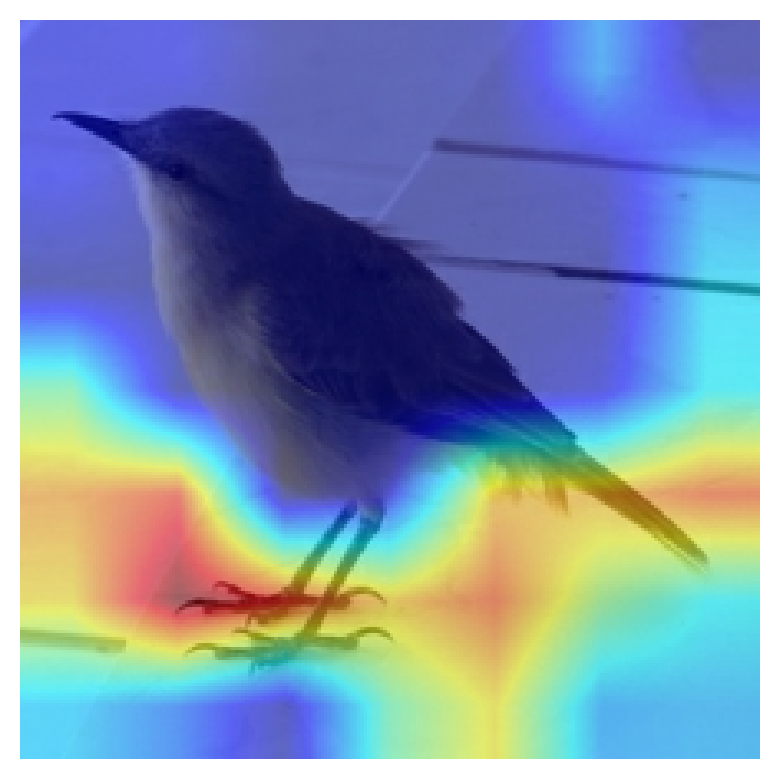

In [94]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Define the index of the image to select
n = 15  # Replace with the desired index

# Get a single data sample from the test loader
data, target = next(iter(val_loader))
data = data[n:n+1]  # Select the nth image (batch slicing)
data = data.to(device)
data.requires_grad = True  # Ensure gradients are tracked

# Specify the target layer
target_layer = model.blocks[-1][-1].conv_pwl  # Adjust based on your model architecture

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Specify the class index (e.g., 0) to compute CAM for
class_index = target[0].item()  # Replace with your desired class index
targets = [ClassifierOutputTarget(class_index)]

# Generate the CAM
grayscale_cam = cam(input_tensor=data, targets=targets)
grayscale_cam = grayscale_cam[0, :]  # Select the first batch element

# Overlay CAM on the input image
input_image = data[0].permute(1, 2, 0).cpu().detach().numpy()  # Adjust if necessary
input_image_normalized = (input_image - input_image.min()) / (input_image.max() - input_image.min())
cam_image = show_cam_on_image(input_image_normalized, grayscale_cam, use_rgb=True)

# Display the CAM
plt.imshow(cam_image)
plt.axis('off')
plt.show()


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [ ]:
# x = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)

In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("birds-classification-effnetv2-b0.pth")